### Imports

In [19]:
import open3d as o3d
from o3d_tools.visualize import PointCloudProject
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Load data as point cloud objects

In [2]:
project1 = PointCloudProject(project='Project1') ; project2 = PointCloudProject(project='Project2')
project3 = PointCloudProject(project='Project3') ; project4 = PointCloudProject(project='Project4')

### Extract bounding box data
**And check which types of objects (pipes etc.) are in each of the 4 projects**

In [3]:
objs1 = project1.objects_df

print(f"Types of objects in Project 1: {list(objs1.keys())}")
pipes1 = objs1["Pipe"]
scbs1 = objs1["Structural_ColumnBeam"]
sibs1 = objs1["Structural_IBeam"]
hvducts = objs1["HVAC_Duct"]

objs2 = project2.objects_df

print(f"Types of objects in Project 2: {list(objs2.keys())}")
pipes2 = objs2["Pipe"]
scbs2 = objs2["Structural_ColumnBeam"]
sibs2 = objs2["Structural_IBeam"]

objs3 = project3.objects_df

print(f"Types of objects in Project 3: {list(objs3.keys())}")
scbs3 = objs3["Structural_ColumnBeam"]

objs4 = project4.objects_df

print(f"Types of objects in Project 4: {list(objs4.keys())}")
sibs4 = objs4["Structural_IBeam"]

Types of objects in Project 1: ['Structural_ColumnBeam', 'HVAC_Duct', 'Pipe', 'Structural_IBeam']
Types of objects in Project 2: ['Structural_ColumnBeam', 'Pipe', 'Structural_IBeam']
Types of objects in Project 3: ['Structural_ColumnBeam']
Types of objects in Project 4: ['Structural_IBeam']


### Join bounding box data
**Currently we have bounding box data grouped by different object types and by projects, merge all this bounding box data into a single dataframe**

In [4]:
boxes1 = pd.concat([scbs1, hvducts, pipes1, sibs1])
boxes2 = pd.concat([scbs2, pipes2, sibs2])
boxes3 = scbs3
boxes4 = sibs4

boxes = [boxes1, boxes2, boxes3, boxes4]

for i in range(len(boxes)):
    boxes[i].rename(columns={" Label": "label", " BB.Min.X " : "min_x", " BB.Min.Y " : "min_y", " BB.Min.Z " : "min_z",
                         " BB.Max.X " : "max_x", " BB.Max.Y " : "max_y", " BB.Max.Z" : "max_z"}, inplace=True)
    
box_data = pd.concat(boxes)

In [5]:
box_data.head()

,ID,label,min_x,min_y,min_z,max_x,max_y,max_z
0,d442ca7c-770d-4bc2-a565-81b971e1b3b3,Structural_ColumnBeam,-221.953285,334.091068,83.833336,-219.536613,336.507724,98.874596
1,de9a038a-e106-48fa-ac76-3f83dfa1503a,Structural_ColumnBeam,-221.953285,315.091068,83.833336,-219.536613,317.507724,98.874611
2,b351dae6-0cf2-45f2-bbfd-ab9e607bce0d,HVAC_Duct,-206.833503,337.267214,95.083333,-203.333503,341.100548,98.250000
3,62e75328-ddda-48d4-87c4-210afb055eb5,HVAC_Duct,-204.791837,332.154501,94.708333,-200.041837,338.154501,98.625000
4,64ca25ff-ebc8-4e83-9585-756d6b711a3c,HVAC_Duct,-204.791837,327.477417,94.708333,-200.041837,334.144084,98.625000


### Map bounding boxes to their corresponding points
**Create a dictionary that maps object ids to the points that make up these objects using PointCloudProject.pcd.crop() method**

In [45]:
ids_to_points = {}

projects = [project1, project2, project3, project4]

for proj_id, box in enumerate(boxes):
    
    for i, ID in enumerate(box["ID"]):
        
        proj = projects[proj_id]
        
        # .pcd.crop() method expects this bounding box object, create it from the raw min max values
        bb = o3d.geometry.AxisAlignedBoundingBox((box[["min_x", "min_y", "min_z"]].iloc[i]).to_numpy(), 
                                    (box[["max_x", "max_y", "max_z"]].iloc[i]).to_numpy())
        
        points_of_id = proj.pcd.crop(bb)
        
        # convert the pointcloud object into a numpy array
        # join coordinates and color data into a single 6d nparray for each point
            
        points_coords = np.asarray(points_of_id.points)
        
        tmp = np.asarray(points_of_id.colors)[:,0]
        
        points_colors = (np.asarray(points_of_id.colors)[:,0]).reshape(-1,1)
        
        points_arr = np.concatenate((points_coords, points_colors), axis = 1)
        
        ids_to_points[ID] = points_arr
        

In [39]:
ids_to_points['d442ca7c-770d-4bc2-a565-81b971e1b3b3'][0]

array([-2.20789548e+02,  3.36146713e+02,  9.82472226e+01,  1.95312500e-01])

### Check min and max number of data points which correspond to an object

In [18]:
sizes = []

for obj_id in ids_to_points.keys():
    
    pc_size = ids_to_points[obj_id].shape[0]
    sizes.append(pc_size)

print(max(sizes))
print(min(sizes))
print(len(size_0))

318284
206
0


### EDA

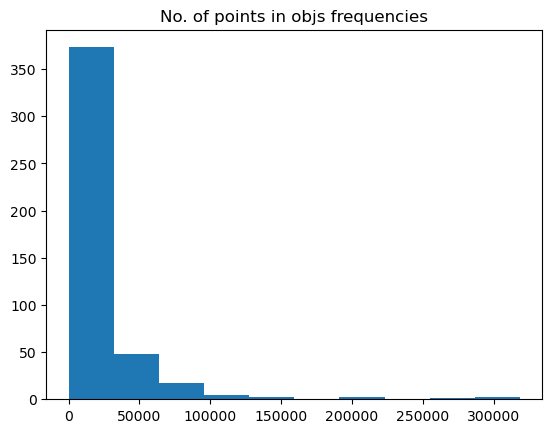

In [22]:
plt.hist(sizes)
plt.title("No. of points in objs frequencies");

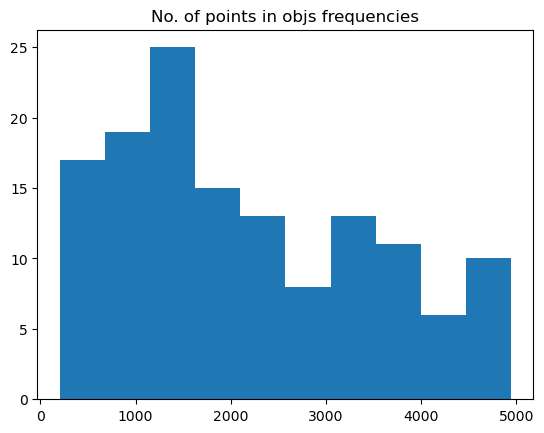

In [24]:
under_5000 = [x for x in sizes if x < 5000]
plt.hist(under_5000)
plt.title("No. of points in objs frequencies");

In [26]:
no_under_5000 = len(under_5000)
print(no_under_5000)
print(no_under_5000 / len(sizes))

137
0.30444444444444446


### Color preprocessing

### Uniform sampling
**If number of data points is smaller than a fixed number upsample, if it's bigger downsample**

In [27]:
def sample_point_cloud(points, num_points):

    if points.shape[0] > num_points:
        
        # Downsample if the point cloud has more points than needed
        idx = np.random.choice(points.shape[0], num_points, replace=False)
        return points[idx, :]
    
    elif points.shape[0] < num_points:
        # Upsample by repeating random points if the point cloud has fewer points than needed
        idx = np.random.choice(points.shape[0], num_points - points.shape[0], replace=True)
        return np.concatenate([points, points[idx, :]], axis=0)
    
    else:
        # Return the point cloud as is if it already has the correct number of points
        return points


In [48]:
fixed_num_points = 2048  # The fixed number of points for all point clouds

point_clouds_resampled = {}

for obj_id in ids_to_points.keys():
    
    point_cloud = ids_to_points[obj_id]
    resampled_points = sample_point_cloud(point_cloud, fixed_num_points)
    point_clouds_resampled[obj_id] = resampled_points

# Convert the list into a numpy array (batch_size x num_points x 3)
#point_clouds_resampled = np.array(point_clouds_resampled)

In [53]:
for obj_id in ids_to_points.keys():
    
    assert point_clouds_resampled[obj_id].shape == (2048, 4)

In [52]:
point_clouds_resampled['d442ca7c-770d-4bc2-a565-81b971e1b3b3'].shape

(2048, 4)

### Split data into train, validation and test set
**Using a 60 20 20 split**

In [17]:
y = box_data["label"]
X = box_data[["ID", "min_x", "min_y", "min_z", "max_x", "max_y", "max_z"]]

In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(270, 7)
(90, 7)
(90, 7)
(270,)
(90,)
(90,)
